# Using tree sequences for pop gen inference

Tree sequences are efficient, easy to deal with, and potentially very informative for inference of demographic events. By using spatial relationships (eg RF distance) along the sequence as predictive features we may be able to better infer demographic events even when using inferred trees.

In [65]:
import msprime
from IPython.display import SVG
from dendropy.calculate.treecompare import symmetric_difference
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from ete3 import Tree
import tsinfer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix

Running replicates https://tskit.dev/msprime/docs/stable/replication.html#sec-randomness-replication

In [42]:
#Simulate 200 reps
L=1e6
N= 10000
n_reps = 100

#Neut
neut_reps = msprime.sim_ancestry(
    1000, 
    recombination_rate=1e-8, 
    sequence_length=L, 
    ploidy=1, 
    population_size=N, 
    num_replicates=n_reps)

neut_mts = [msprime.sim_mutations(ts, rate=1e-8) for ts in neut_reps]

for idx, ts in enumerate(neut_mts):
    ts.dump(f"treeseqs/neut/{idx}.trees")

print("Done with neuts")

#Hard sweep
sweep_model = msprime.SweepGenicSelection(
    position=L / 2,  # beneficial mutation location: middle of chrom
    start_frequency=1.0 / (2 * N), # starting frequency of the sweeping mutation
    end_frequency=0.99, # final frequency of the mutation (incomplete sweep)
    s=0.25, # selection coefficient of the beneficial mutation
    dt=1e-6, # nevermind this!
)

sweep_reps = msprime.sim_ancestry(
    1000,
    model=[sweep_model, msprime.StandardCoalescent()],
    population_size=N,
    recombination_rate=1e-8,
    sequence_length=L,
    ploidy=1,
    num_replicates=n_reps
)

sweep_mts = [msprime.sim_mutations(ts, rate=1e-8) for ts in sweep_reps]

for idx, ts in enumerate(sweep_mts):
    ts.dump(f"treeseqs/sweep/{idx}.trees")

print("Done with sweeps")

Done with neuts
Done with sweeps


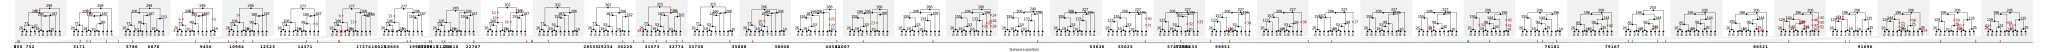

In [43]:
SVG(neut_mts[0].simplify(range(10)).draw_svg(time_scale="rank", x_lim=(0, 100000)))


In [44]:
def get_middle_win(iterable, k=51):
    """Given a list/iterable and window size get middle"""
    center_idx = int(len(iterable)/2)
    half_win = int(k/2)

    return [iterable[i] for i in range(center_idx - half_win, center_idx + half_win)]

In [45]:
def calc_ts_rf(ts):
    """
    Iterate through a tree sequence
        convert to newick
        convert to ETE object
        calculate pairwise RF dists
    """
    trees = [tree.as_newick() for tree in ts.trees()]
    etes = [Tree(tree) for tree in get_middle_win(trees)]
    rfs = []
    for idx in range(len(etes)-1):
        rfs.append(etes[idx].robinson_foulds(etes[idx+1])[0])
    
    return rfs

In [46]:
#Read in trees to ete3 through newick conversion, calc RFs while in memory, move on to next
neut_reps_rfs = []
sweep_reps_rfs = []
for neut_rep, sweep_rep in tqdm(zip(neut_mts, sweep_mts), total=len(neut_mts)):
    neut_reps_rfs.append(calc_ts_rf(neut_rep))
    sweep_reps_rfs.append(calc_ts_rf(sweep_rep))


100%|██████████| 100/100 [18:33<00:00, 11.13s/it]


If we pull some metrics about the resulting distributions it's pretty clear that spatially-resolved RF distances are drastically different in the pattern we'd also expect from pi under sweep conditions

In [48]:
#RF Dist Stats
neut_arr = np.array(neut_reps_rfs)
sweep_arr = np.array(sweep_reps_rfs)

np.savetxt("neut_data.tsv", neut_arr, delimiter="\t")
np.savetxt("sweep_data.tsv", sweep_arr, delimiter="\t")

print(neut_arr.shape)

neut_df = pd.DataFrame(neut_arr.T)
sweep_df = pd.DataFrame(sweep_arr.T)

print("Neutral")
print(neut_df.describe())

print("\nSweep")
print(sweep_df.describe())

(100, 49)
Neutral
              0          1          2          3          4          5   \
count  49.000000  49.000000  49.000000  49.000000  49.000000  49.000000   
mean   13.469388  14.979592  13.918367  14.571429  15.755102  11.346939   
std    12.184522  12.616936  13.904191  13.121230  13.623709  10.672299   
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
25%     4.000000   6.000000   2.000000   4.000000   4.000000   2.000000   
50%     8.000000  12.000000   8.000000  14.000000  14.000000   8.000000   
75%    20.000000  22.000000  22.000000  20.000000  26.000000  20.000000   
max    46.000000  46.000000  50.000000  54.000000  54.000000  30.000000   

              6          7          8          9   ...         90         91  \
count  49.000000  49.000000  49.000000  49.000000  ...  49.000000  49.000000   
mean   16.489796  15.836735  13.836735  13.714286  ...  11.836735  13.632653   
std    13.301194  13.752798  12.870099  13.063945  ...  11.253420 

<AxesSubplot:title={'center':'Sweep RF Dists'}, xlabel='Tree Pair Index', ylabel='RF Distance'>

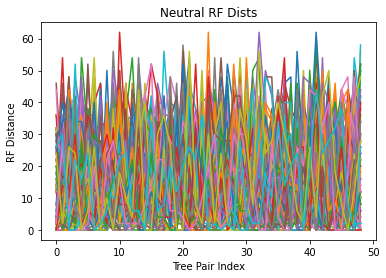

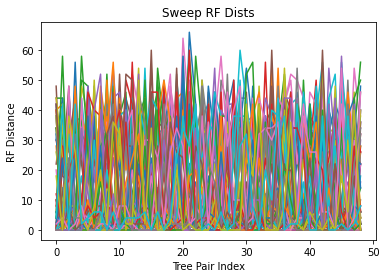

In [73]:
#Plot location-based RF
neut_df.plot(title="Neutral RF Dists", ylabel="RF Distance", xlabel="Tree Pair Index", legend=None)
sweep_df.plot(title="Sweep RF Dists", ylabel="RF Distance", xlabel="Tree Pair Index", legend=None)

Now we create and train an RF model to use this as a predictive feature

In [53]:
#Split train/test
data = np.concatenate([neut_arr, sweep_arr], axis=0)
labs = np.concatenate([len(neut_arr)*[0], len(sweep_arr)*[1]])

x_train, x_test, y_train, y_test = train_test_split(data, labs, stratify=labs)

(150,)

In [56]:
#RF model
clf = RandomForestClassifier()
clf.fit(x_train, y_train)

pred = clf.predict_proba(x_test)

roc_auc = roc_auc_score(y_test, pred[:,1])
print(f"ROC AUC: {roc_auc}")

confmat = confusion_matrix(y_test, np.argmax(pred, axis=1))
print("Confusion matrix")
print(confmat)


ROC AUC: 0.9639999999999999
Confusion matrix
[[22  3]
 [ 2 23]]


---


# Now do the entire thing again but with inferred trees

Much harder problem to solve because now information in the tree sequence is bottlenecked by ability to infer

In [67]:
neut_inferred_ts = []
sweep_inferred_ts = []

for idx, (neut_rep, sweep_rep) in tqdm(enumerate(zip(neut_mts, sweep_mts)), total=len(neut_mts)):
    neut_samp = tsinfer.SampleData.from_tree_sequence(
        neut_rep,
        path=f"samples/neut/{idx}.samples",
        num_flush_threads=2)

    neut_inferred_ts.append(tsinfer.infer(neut_samp))

    sweep_samp = tsinfer.SampleData.from_tree_sequence(
        sweep_rep,
        path=f"samples/sweep/{idx}.samples",
        num_flush_threads=2)

    sweep_inferred_ts.append(tsinfer.infer(sweep_samp))


100%|██████████| 100/100 [16:18<00:00,  9.78s/it]


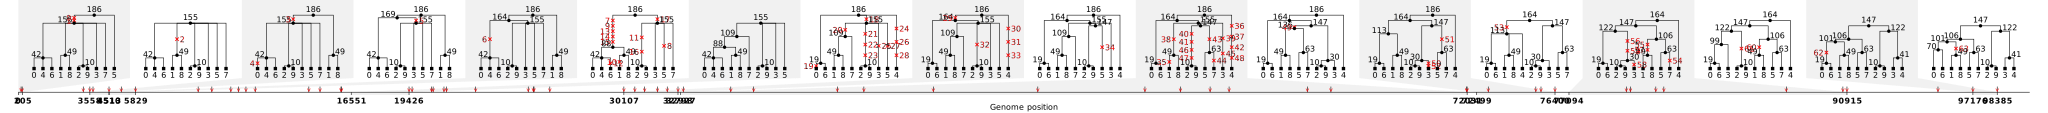

In [68]:
SVG(neut_inferred_ts[0].simplify(range(10)).draw_svg(time_scale="rank", x_lim=(0, 100000)))


In [69]:
#Read in trees to ete3 through newick conversion, calc RFs while in memory, move on to next
neut_reps_inferred_rfs = []
sweep_reps_inferred_rfs = []
for neut_rep, sweep_rep in tqdm(zip(neut_inferred_ts, sweep_inferred_ts), total=len(neut_mts)):
    neut_reps_inferred_rfs.append(calc_ts_rf(neut_rep))
    sweep_reps_inferred_rfs.append(calc_ts_rf(sweep_rep))


100%|██████████| 100/100 [17:13<00:00, 10.33s/it]


In [71]:
#RF Dist Stats
neut_inferred_arr = np.array(neut_reps_inferred_rfs)
sweep_inferred_arr = np.array(sweep_reps_inferred_rfs)

np.savetxt("neut_inferred_data.tsv", neut_arr, delimiter="\t")
np.savetxt("sweep_inferred_data.tsv", sweep_arr, delimiter="\t")

neut_inferred_df = pd.DataFrame(neut_inferred_arr.T)
sweep_inferred_df = pd.DataFrame(sweep_inferred_arr.T)

print("Neutral")
print(neut_inferred_df.describe())

print("\nSweep")
print(sweep_inferred_df.describe())

(100, 49)
Neutral
              0          1          2          3          4          5   \
count  49.000000  49.000000  49.000000  49.000000  49.000000  49.000000   
mean   17.612245  17.224490  20.142857  15.224490  17.755102  17.061224   
std    14.934323  13.855302  17.926935  15.724537  12.341547  15.615708   
min     1.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
25%     6.000000   6.000000   6.000000   3.000000   9.000000   5.000000   
50%    16.000000  15.000000  14.000000  13.000000  16.000000  16.000000   
75%    25.000000  25.000000  32.000000  22.000000  24.000000  24.000000   
max    62.000000  52.000000  79.000000  81.000000  52.000000  91.000000   

              6          7          8          9   ...         90         91  \
count  49.000000  49.000000  49.000000  49.000000  ...  49.000000  49.000000   
mean   15.673469  20.346939  20.632653  17.877551  ...  19.979592  14.693878   
std    13.357875  14.154727  16.802398  12.137464  ...  13.876674 

<AxesSubplot:title={'center':'Sweep RF Dists'}, xlabel='Tree Pair Index', ylabel='RF Distance'>

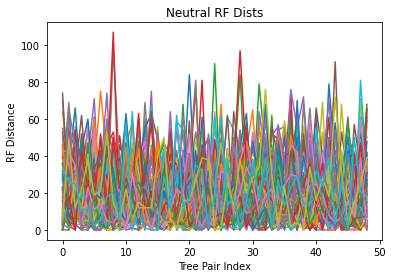

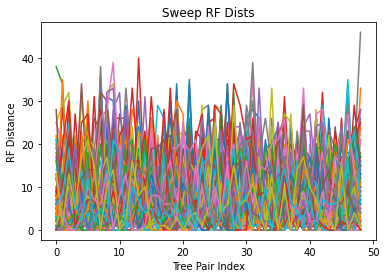

In [72]:
#Plot location-based RF
neut_inferred_df.plot(title="Neutral RF Dists", ylabel="RF Distance", xlabel="Tree Pair Index", legend=None)
sweep_inferred_df.plot(title="Sweep RF Dists", ylabel="RF Distance", xlabel="Tree Pair Index", legend=None)

Now we create and train an RF model to use this as a predictive feature

In [74]:
#Split train/test
data = np.concatenate([neut_inferred_arr, sweep_inferred_arr], axis=0)
labs = np.concatenate([len(neut_inferred_arr)*[0], len(sweep_inferred_arr)*[1]])

x_train, x_test, y_train, y_test = train_test_split(data, labs, stratify=labs)

In [76]:
#RF model
clf_inf = RandomForestClassifier()
clf_inf.fit(x_train, y_train)

pred = clf_inf.predict_proba(x_test)

roc_auc = roc_auc_score(y_test, pred[:,1])
print(f"Inferred ROC AUC: {roc_auc}")

confmat = confusion_matrix(y_test, np.argmax(pred, axis=1))
print("Inferred Confusion matrix")
print(confmat)



Inferred ROC AUC: 1.0
Inferred Confusion matrix
[[24  1]
 [ 0 25]]
